Data fields
Each row of the training data contains a click record, with the following features.

ip: ip address of click.

app: app id for marketing.

device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

os: os version id of user mobile phone

channel: channel id of mobile ad publisher

click_time: timestamp of click (UTC)

attributed_time: if user download the app for after clicking an ad, this is the time of the app download

is_attributed: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

click_id: reference for making predictions

is_attributed: not included

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import datetime


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test_supplement.csv', 'train.csv', 'test.csv', 'sample_submission.csv', 'train_sample.csv']


In [47]:
data_types = {
    'ip' : 'uint32',
    'app' : 'uint16',
    'device' : 'uint16',
    'os' : 'uint16',
    'channel' : 'uint16',
    'is_attributed' : 'bool'
}

In [48]:
sample_train = pd.read_csv('../input/train_sample.csv', dtype=data_types)

In [49]:
sample_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null uint32
app                100000 non-null uint16
device             100000 non-null uint16
os                 100000 non-null uint16
channel            100000 non-null uint16
click_time         100000 non-null object
attributed_time    251 non-null object
is_attributed      100000 non-null bool
dtypes: bool(1), object(2), uint16(4), uint32(1)
memory usage: 2.8+ MB


In [50]:
(sample_train.groupby(['ip']).ip.count() == 1).values

array([False, False, False, ...,  True,  True,  True])

In [51]:
(sample_train.groupby('ip').is_attributed.sum()/sample_train.groupby('ip').is_attributed.count()).value_counts()

0.000000    34438
1.000000      137
0.500000       25
0.250000       14
0.333333       14
0.200000        8
0.142857        8
0.111111        7
0.076923        6
0.083333        3
0.166667        3
0.090909        3
0.100000        2
0.125000        2
0.037037        1
0.011111        1
0.015873        1
0.031250        1
0.062500        1
0.066667        1
0.020833        1
0.029412        1
0.023810        1
0.043478        1
0.004687        1
0.055556        1
0.030303        1
0.012346        1
0.038462        1
0.058824        1
Name: is_attributed, dtype: int64

In [52]:
sample_train['click_time'] = pd.to_datetime(sample_train['click_time'])
sample_train['attributed_time'] = pd.to_datetime(sample_train['attributed_time'])

In [53]:
sample_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null uint32
app                100000 non-null uint16
device             100000 non-null uint16
os                 100000 non-null uint16
channel            100000 non-null uint16
click_time         100000 non-null datetime64[ns]
attributed_time    251 non-null datetime64[ns]
is_attributed      100000 non-null bool
dtypes: bool(1), datetime64[ns](2), uint16(4), uint32(1)
memory usage: 2.8 MB


In [54]:
sample_click_list = sample_train[~sample_train['attributed_time'].isnull()].sort_values(['ip', 'click_time']).reset_index().drop(['index', 'is_attributed'], axis =1)
sample_click_list

,ip,app,device,os,channel,click_time,attributed_time
0,2965,19,0,29,213,2017-11-08 10:05:27,2017-11-08 15:41:14
1,3355,19,0,0,213,2017-11-09 12:55:33,2017-11-09 13:06:27
2,3808,35,1,25,274,2017-11-07 06:34:10,2017-11-07 07:07:20
3,3845,2,1,19,477,2017-11-08 07:32:48,2017-11-08 07:43:14
4,4382,19,0,38,213,2017-11-07 22:27:12,2017-11-07 22:27:56
5,5072,35,1,19,21,2017-11-09 02:25:58,2017-11-09 03:45:33
6,5314,19,88,24,213,2017-11-07 22:25:07,2017-11-07 22:25:17
7,5314,20,1,27,478,2017-11-08 06:42:28,2017-11-08 07:55:46
8,5314,19,0,0,347,2017-11-09 08:11:01,2017-11-09 08:11:05
9,6380,19,0,24,213,2017-11-08 16:16:37,2017-11-09 01:28:25


In [55]:
sample_click_list.ip.unique().size

248

In [56]:
for col in sample_train:
    print (col,'\t',sample_train[col].unique().size)

ip 	 34686
app 	 156
device 	 99
os 	 132
channel 	 162
click_time 	 80355
attributed_time 	 252
is_attributed 	 2


In [57]:
sample_click_list.os.sort_values().unique()

array([  0,   1,   4,   6,   7,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  24,  25,  27,  29,  30,  32,  35,
        36,  37,  38,  40,  41,  43,  44,  47,  50,  55,  61,  76, 109,
       135], dtype=uint64)

**Visualization**

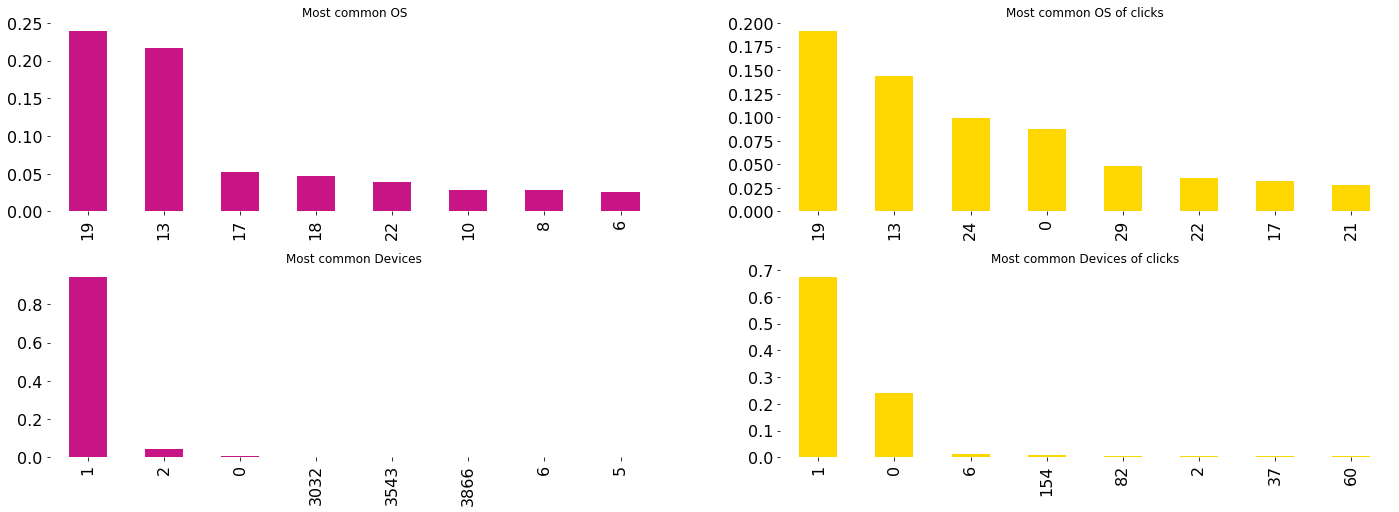

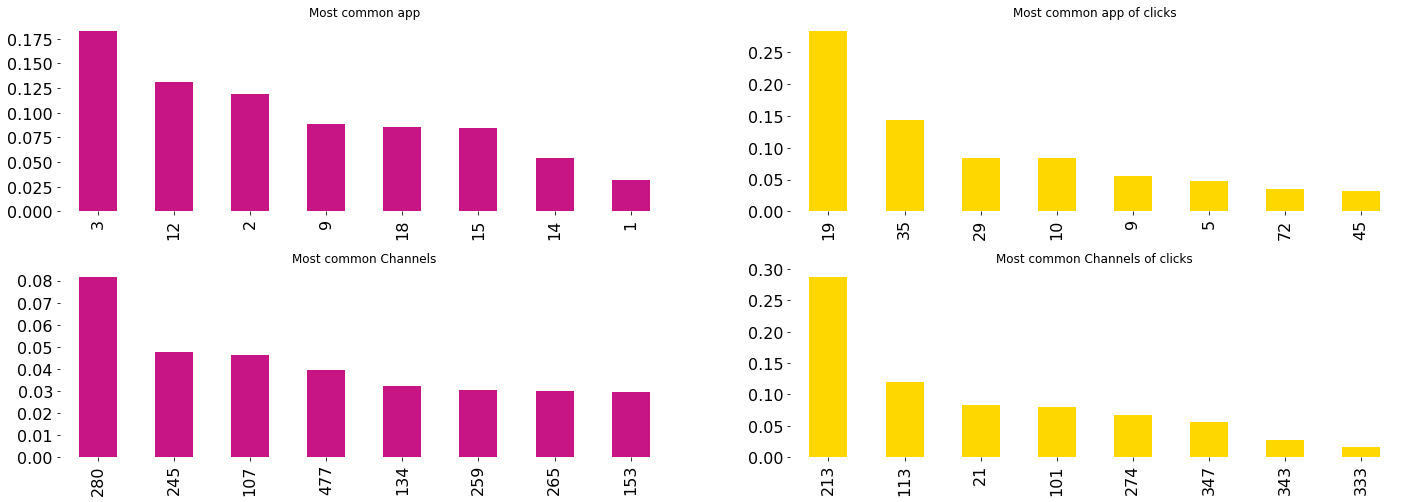

In [58]:
fig, axarr = plt.subplots(2,2, figsize=(24,8))

(sample_train.os.value_counts()[:8]/sample_train.os.count()).plot.bar(color='mediumvioletred', ax =axarr[0][0], fontsize = 16)
axarr[0][0].set_title('Most common OS')
(sample_click_list.os.value_counts()[:8]/sample_click_list.os.count()).plot.bar(color='gold', ax =axarr[0][1], fontsize = 16)
axarr[0][1].set_title('Most common OS of clicks')
(sample_train.device.value_counts()[:8]/sample_train.device.count()).plot.bar(color='mediumvioletred', ax =axarr[1][0], fontsize = 16)
axarr[1][0].set_title('Most common Devices')
(sample_click_list.device.value_counts()[:8]/sample_click_list.device.count()).plot.bar(color='gold', ax =axarr[1][1], fontsize = 16)
axarr[1][1].set_title('Most common Devices of clicks')

plt.subplots_adjust(hspace=.3)

sns.despine(bottom=True, left=True)

fig_2, axarr_2 = plt.subplots(2,2, figsize=(24,8))

(sample_train.app.value_counts()[:8]/sample_train.app.count()).plot.bar(color='mediumvioletred', ax =axarr_2[0][0], fontsize = 16)
axarr_2[0][0].set_title('Most common app')
(sample_click_list.app.value_counts()[:8]/sample_click_list.app.count()).plot.bar(color='gold', ax =axarr_2[0][1], fontsize = 16)
axarr_2[0][1].set_title('Most common app of clicks')
(sample_train.channel.value_counts()[:8]/sample_train.channel.count()).plot.bar(color='mediumvioletred', ax =axarr_2[1][0], fontsize = 16)
axarr_2[1][0].set_title('Most common Channels')
(sample_click_list.channel.value_counts()[:8]/sample_click_list.channel.count()).plot.bar(color='gold', ax =axarr_2[1][1], fontsize = 16)
axarr_2[1][1].set_title('Most common Channels of clicks')

plt.subplots_adjust(hspace=.3)

sns.despine(bottom=True, left=True)